In [94]:
import psycopg2
import json
import pandas as pd
import geopandas as gpd
from shapely.geometry import shape
from shapely.geometry import LineString, MultiLineString
import matplotlib.pyplot as plt

from config import DB_VISION_ZERO, DB_MOPED
from helper import dict_factory, to_json_list

In [95]:
def get_data(query, cursor):
    """
    Get data from database
    """
    cursor.execute(query)
    data = cursor.fetchall()
    field_names = [i[0] for i in cursor.description]
    df = pd.DataFrame(data, columns=field_names)

    return df

conn_vz = psycopg2.connect(
    dbname = DB_VISION_ZERO['dbname'],
    user = DB_VISION_ZERO["user"],
    host = DB_VISION_ZERO["host"],
    password = DB_VISION_ZERO["password"],
    port=5432
)

conn_moped = psycopg2.connect(
    dbname = DB_MOPED["dbname"],
    user = DB_MOPED["user"],
    host = DB_MOPED["host"],
    password = DB_MOPED["password"],
    port = 5432
)

cursor_vz = conn_vz.cursor()
cursor_moped = conn_moped.cursor()

# Moped processing

In [96]:
# Creating moped dataframe
QUERY_MOPED = """SELECT project_id, project_component_id, geometry, 
line_geometry, substantial_completion_date, 
substantial_completion_date_estimated, completion_date, completion_end_date
FROM component_arcgis_online_view"""

# Creating moped dataframe
df_moped = get_data(QUERY_MOPED, cursor_moped)

In [97]:
# Data frame info
df_moped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12065 entries, 0 to 12064
Data columns (total 7 columns):
 #   Column                                 Non-Null Count  Dtype              
---  ------                                 --------------  -----              
 0   project_id                             12065 non-null  int64              
 1   project_component_id                   11607 non-null  float64            
 2   geometry                               11607 non-null  object             
 3   line_geometry                          11607 non-null  object             
 4   substantial_completion_date_estimated  12065 non-null  object             
 5   completion_date                        349 non-null    datetime64[ns, UTC]
 6   completion_end_date                    196 non-null    datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](2), float64(1), int64(1), object(3)
memory usage: 659.9+ KB


In [98]:
# Dropping observations where completion end date is not present
df_moped_filter = df_moped.dropna(subset=['completion_end_date'])
df_moped_filter.head()

,project_id,project_component_id,geometry,line_geometry,substantial_completion_date_estimated,completion_date,completion_end_date
4,12,181.0,"{'type': 'MultiPoint', 'coordinates': [[-97.73...","{'type': 'LineString', 'coordinates': [[-97.73...",2024-01-01T00:00:00-06:00,NaT,2022-12-30 06:00:00+00:00
14,52,56.0,"{'type': 'MultiPoint', 'coordinates': [[-97.73...","{'type': 'LineString', 'coordinates': [[-97.73...",2024-01-01T00:00:00-06:00,2021-08-24 05:00:00+00:00,2021-08-24 05:00:00+00:00
15,57,61.0,"{'type': 'MultiPoint', 'coordinates': [[-97.78...","{'type': 'LineString', 'coordinates': [[-97.78...",2024-01-01T00:00:00-06:00,NaT,2022-03-31 05:00:00+00:00
20,75,79.0,"{'type': 'MultiPoint', 'coordinates': [[-97.73...","{'type': 'LineString', 'coordinates': [[-97.73...",2024-01-01T00:00:00-06:00,NaT,2022-08-26 05:00:00+00:00
22,87,91.0,"{'type': 'MultiPoint', 'coordinates': [[-97.74...","{'type': 'LineString', 'coordinates': [[-97.74...",2024-01-01T00:00:00-06:00,2021-12-03 06:00:00+00:00,2021-12-31 06:00:00+00:00


In [99]:
# Convert timestamp columns to string using .loc
timestamp_columns = ["substantial_completion_date_estimated", 
                     "completion_date", 
                     "completion_end_date"]

for col in timestamp_columns:
    df_moped_filter.loc[:, col] = df_moped_filter[col].astype(str)

# Apply the geometry transformation using .loc
df_moped_filter.loc[:, "geometry"] = df_moped_filter["geometry"].apply(lambda x: shape(x) if x is not None else None)

# Create GeoDataFrame
gdf_moped = gpd.GeoDataFrame(df_moped_filter, geometry="geometry")

In [100]:
gdf_moped.head()

,project_id,project_component_id,geometry,line_geometry,substantial_completion_date_estimated,completion_date,completion_end_date
4,12,181.0,MULTIPOINT (-97.73351 30.26751),"{'type': 'LineString', 'coordinates': [[-97.73...",2024-01-01T00:00:00-06:00,NaT,2022-12-30 06:00:00+00:00
14,52,56.0,MULTIPOINT (-97.73073 30.28503),"{'type': 'LineString', 'coordinates': [[-97.73...",2024-01-01T00:00:00-06:00,2021-08-24 05:00:00+00:00,2021-08-24 05:00:00+00:00
15,57,61.0,MULTIPOINT (-97.78528 30.17296),"{'type': 'LineString', 'coordinates': [[-97.78...",2024-01-01T00:00:00-06:00,NaT,2022-03-31 05:00:00+00:00
20,75,79.0,MULTIPOINT (-97.73648 30.26524),"{'type': 'LineString', 'coordinates': [[-97.73...",2024-01-01T00:00:00-06:00,NaT,2022-08-26 05:00:00+00:00
22,87,91.0,MULTIPOINT (-97.74215 30.41752),"{'type': 'LineString', 'coordinates': [[-97.74...",2024-01-01T00:00:00-06:00,2021-12-03 06:00:00+00:00,2021-12-31 06:00:00+00:00


In [101]:
gdf_moped.explore()

TypeError: Object of type Timestamp is not JSON serializable

In [137]:
df_moped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12065 entries, 0 to 12064
Data columns (total 7 columns):
 #   Column                                 Non-Null Count  Dtype              
---  ------                                 --------------  -----              
 0   project_id                             12065 non-null  int64              
 1   project_component_id                   11607 non-null  float64            
 2   geometry                               11607 non-null  object             
 3   line_geometry                          11607 non-null  object             
 4   substantial_completion_date_estimated  12065 non-null  object             
 5   completion_date                        349 non-null    datetime64[ns, UTC]
 6   completion_end_date                    196 non-null    datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](2), float64(1), int64(1), object(3)
memory usage: 659.9+ KB


In [136]:
df_moped_filter.info()

<class 'pandas.core.frame.DataFrame'>
Index: 196 entries, 4 to 12061
Data columns (total 7 columns):
 #   Column                                 Non-Null Count  Dtype              
---  ------                                 --------------  -----              
 0   project_id                             196 non-null    int64              
 1   project_component_id                   196 non-null    float64            
 2   geometry                               196 non-null    object             
 3   line_geometry                          196 non-null    object             
 4   substantial_completion_date_estimated  196 non-null    object             
 5   completion_date                        22 non-null     datetime64[ns, UTC]
 6   completion_end_date                    196 non-null    datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](2), float64(1), int64(1), object(3)
memory usage: 12.2+ KB


# VisionZero processing

In [102]:
# Creaing vision zero dataframe
QUERY_CRASH_DATA = """SELECT crash_id, crash_fatal_fl, crash_date, rpt_latitude,
rpt_longitude, road_constr_zone_fl, latitude, longitude, tot_injry_cnt, death_cnt 
FROM atd_txdot_crashes"""


df_vz = get_data(QUERY_CRASH_DATA, cursor_vz)

In [103]:
df_vz.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417362 entries, 0 to 417361
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   crash_id             417362 non-null  int64  
 1   crash_fatal_fl       417362 non-null  object 
 2   crash_date           417362 non-null  object 
 3   rpt_latitude         62289 non-null   float64
 4   rpt_longitude        62289 non-null   float64
 5   road_constr_zone_fl  417360 non-null  object 
 6   latitude             385993 non-null  float64
 7   longitude            385993 non-null  float64
 8   tot_injry_cnt        417360 non-null  float64
 9   death_cnt            417361 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 31.8+ MB


In [104]:
# Filtering

# Keepiing only those observations where x-y coordinates are present
df_vz_filter = df_vz[df_vz['latitude'].notnull() & df_vz['longitude'].notnull()]

In [138]:
df_vz_filter.info()

<class 'pandas.core.frame.DataFrame'>
Index: 385993 entries, 0 to 417361
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   crash_id             385993 non-null  int64  
 1   crash_fatal_fl       385993 non-null  object 
 2   crash_date           385993 non-null  object 
 3   rpt_latitude         60123 non-null   float64
 4   rpt_longitude        60123 non-null   float64
 5   road_constr_zone_fl  385993 non-null  object 
 6   latitude             385993 non-null  float64
 7   longitude            385993 non-null  float64
 8   tot_injry_cnt        385993 non-null  float64
 9   death_cnt            385993 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 32.4+ MB


In [105]:
# Convert timestamp columns to string using .loc
timestamp_columns = ["crash_date"]

for col in timestamp_columns:
    df_vz_filter.loc[:, col] = df_vz_filter[col].astype(str)

In [106]:
# Creating geodataframe
gdf_vz = gpd.GeoDataFrame(df_vz_filter,
                          geometry=gpd.points_from_xy(df_vz_filter.longitude,
                                                      df_vz_filter.latitude),
                                                      crs='EPSG:4326')

gdf_vz.head()

,crash_id,crash_fatal_fl,crash_date,rpt_latitude,rpt_longitude,road_constr_zone_fl,latitude,longitude,tot_injry_cnt,death_cnt,geometry
0,11314578,N,2010-04-15,NaN,NaN,N,29.923835,-97.892288,1.0,0.0,POINT (-97.89229 29.92383)
1,11489926,N,2010-06-18,30.13615,-97.89322,N,30.136109,-97.893241,0.0,0.0,POINT (-97.89324 30.13611)
3,11807849,N,2010-12-12,NaN,NaN,N,30.463422,-97.989550,0.0,0.0,POINT (-97.98955 30.46342)
4,11638589,N,2010-09-23,NaN,NaN,N,29.946176,-97.880773,1.0,0.0,POINT (-97.88077 29.94618)
5,11568073,N,2010-07-31,29.96920,-97.77347,N,29.969169,-97.773431,0.0,0.0,POINT (-97.77343 29.96917)


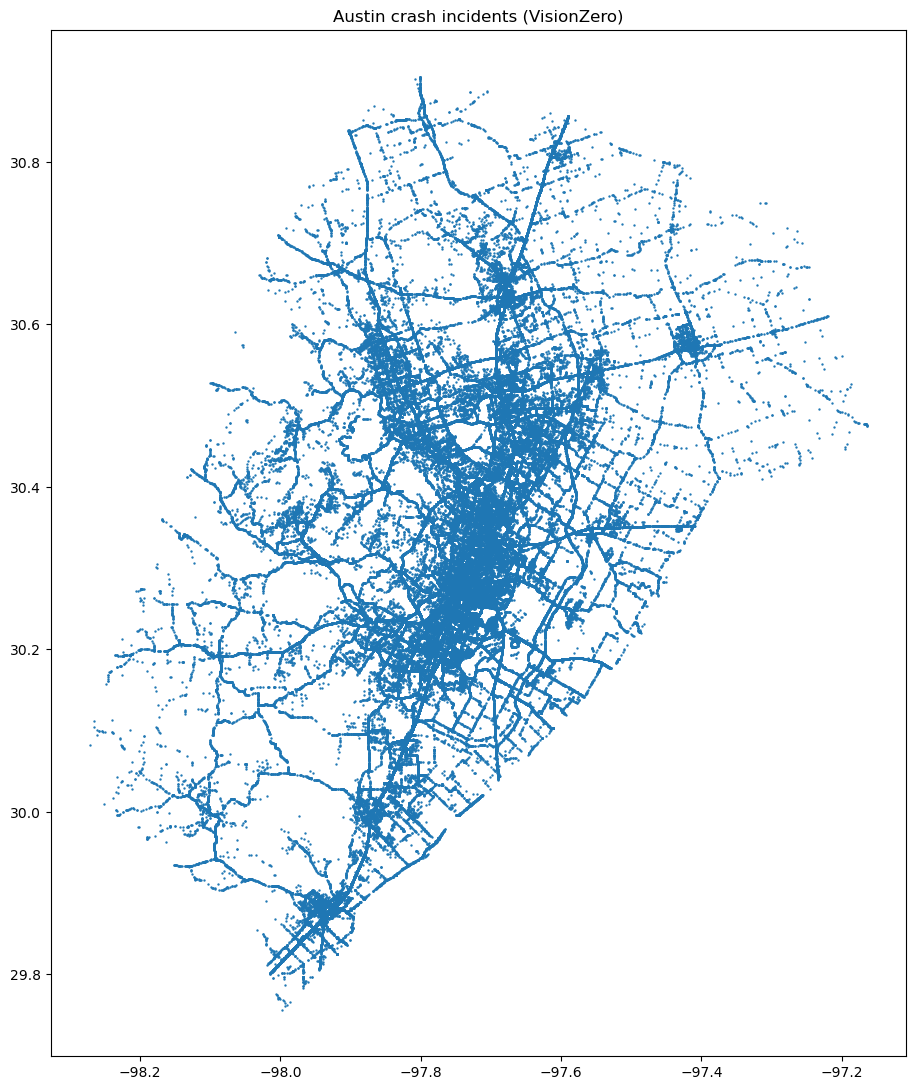

In [107]:
# Plotting
fig, ax = plt.subplots(figsize=(20, 13.33))
gdf_vz.plot(ax=ax, markersize=0.5)  
plt.title('Austin crash incidents (VisionZero)')
plt.show()

# Spatial join

In [108]:
gdf_vz.head()

,crash_id,crash_fatal_fl,crash_date,rpt_latitude,rpt_longitude,road_constr_zone_fl,latitude,longitude,tot_injry_cnt,death_cnt,geometry
0,11314578,N,2010-04-15,NaN,NaN,N,29.923835,-97.892288,1.0,0.0,POINT (-97.89229 29.92383)
1,11489926,N,2010-06-18,30.13615,-97.89322,N,30.136109,-97.893241,0.0,0.0,POINT (-97.89324 30.13611)
3,11807849,N,2010-12-12,NaN,NaN,N,30.463422,-97.989550,0.0,0.0,POINT (-97.98955 30.46342)
4,11638589,N,2010-09-23,NaN,NaN,N,29.946176,-97.880773,1.0,0.0,POINT (-97.88077 29.94618)
5,11568073,N,2010-07-31,29.96920,-97.77347,N,29.969169,-97.773431,0.0,0.0,POINT (-97.77343 29.96917)


In [109]:
gdf_moped.head()

,project_id,project_component_id,geometry,line_geometry,substantial_completion_date_estimated,completion_date,completion_end_date
4,12,181.0,MULTIPOINT (-97.73351 30.26751),"{'type': 'LineString', 'coordinates': [[-97.73...",2024-01-01T00:00:00-06:00,NaT,2022-12-30 06:00:00+00:00
14,52,56.0,MULTIPOINT (-97.73073 30.28503),"{'type': 'LineString', 'coordinates': [[-97.73...",2024-01-01T00:00:00-06:00,2021-08-24 05:00:00+00:00,2021-08-24 05:00:00+00:00
15,57,61.0,MULTIPOINT (-97.78528 30.17296),"{'type': 'LineString', 'coordinates': [[-97.78...",2024-01-01T00:00:00-06:00,NaT,2022-03-31 05:00:00+00:00
20,75,79.0,MULTIPOINT (-97.73648 30.26524),"{'type': 'LineString', 'coordinates': [[-97.73...",2024-01-01T00:00:00-06:00,NaT,2022-08-26 05:00:00+00:00
22,87,91.0,MULTIPOINT (-97.74215 30.41752),"{'type': 'LineString', 'coordinates': [[-97.74...",2024-01-01T00:00:00-06:00,2021-12-03 06:00:00+00:00,2021-12-31 06:00:00+00:00


In [110]:
gdf_moped['line_geometry'][0:1]

4    {'type': 'LineString', 'coordinates': [[-97.73...
Name: line_geometry, dtype: object

In [111]:
gdf_moped.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 196 entries, 4 to 12061
Data columns (total 7 columns):
 #   Column                                 Non-Null Count  Dtype              
---  ------                                 --------------  -----              
 0   project_id                             196 non-null    int64              
 1   project_component_id                   196 non-null    float64            
 2   geometry                               196 non-null    geometry           
 3   line_geometry                          196 non-null    object             
 4   substantial_completion_date_estimated  196 non-null    object             
 5   completion_date                        22 non-null     datetime64[ns, UTC]
 6   completion_end_date                    196 non-null    datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](2), float64(1), geometry(1), int64(1), object(2)
memory usage: 12.2+ KB


In [112]:
# Function to parase line_geometry column in the moped data frame
def parse_linestring(line_geom):

    # print(type(line_geom))
    # print(line_geom)

    if line_geom['type'] == 'LineString':
        coordinates = [tuple(coord) for coord in line_geom['coordinates']]
        return LineString(coordinates)
    elif line_geom['type'] == 'MultiLineString':
        lines = [LineString([tuple(coord) for coord in line]) for line in line_geom['coordinates']]
        return MultiLineString(lines)
    else:
        raise ValueError(f"Unexpected geometry type: {line_geom['type']}")

gdf_moped['line_geometry'] = gdf_moped['line_geometry'].apply(parse_linestring)

In [113]:
gdf_moped.head()

,project_id,project_component_id,geometry,line_geometry,substantial_completion_date_estimated,completion_date,completion_end_date
4,12,181.0,MULTIPOINT (-97.73351 30.26751),"LINESTRING (-97.733436244 30.267508296, -97.73...",2024-01-01T00:00:00-06:00,NaT,2022-12-30 06:00:00+00:00
14,52,56.0,MULTIPOINT (-97.73073 30.28503),"LINESTRING (-97.730660231 30.285024294, -97.73...",2024-01-01T00:00:00-06:00,2021-08-24 05:00:00+00:00,2021-08-24 05:00:00+00:00
15,57,61.0,MULTIPOINT (-97.78528 30.17296),"LINESTRING (-97.785211312 30.172954327, -97.78...",2024-01-01T00:00:00-06:00,NaT,2022-03-31 05:00:00+00:00
20,75,79.0,MULTIPOINT (-97.73648 30.26524),"LINESTRING (-97.73640324500001 30.265240298, -...",2024-01-01T00:00:00-06:00,NaT,2022-08-26 05:00:00+00:00
22,87,91.0,MULTIPOINT (-97.74215 30.41752),"LINESTRING (-97.74207713200001 30.417523298, -...",2024-01-01T00:00:00-06:00,2021-12-03 06:00:00+00:00,2021-12-31 06:00:00+00:00


In [114]:
# Adding a unique ID column to the moped data frame
gdf_moped.insert(0, 'moped_component_id', range(1, 1 + len(gdf_moped)))

In [115]:
# Creating buffer for joining
gdf_moped = gdf_moped.set_geometry('line_geometry')
gdf_moped.set_crs(epsg=4326, inplace=True)
gdf_moped_proj = gdf_moped.to_crs(epsg=32614)
buffer_distance = 100

gdf_moped_proj = gdf_moped.to_crs(epsg=32614)

In [116]:
gdf_moped_proj['buffered_geometry'] = gdf_moped_proj.geometry.buffer(buffer_distance)
buffered_moped_gdf = gdf_moped_proj.set_geometry('buffered_geometry').to_crs('EPSG:4326')

In [117]:
buffered_moped_gdf.head()

,moped_component_id,project_id,project_component_id,geometry,line_geometry,substantial_completion_date_estimated,completion_date,completion_end_date,buffered_geometry
4,1,12,181.0,MULTIPOINT (-97.73351 30.26751),"LINESTRING (621833.101 3349106.852, 621832.966...",2024-01-01T00:00:00-06:00,NaT,2022-12-30 06:00:00+00:00,"POLYGON ((-97.73240 30.26759, -97.73240 30.267..."
14,2,52,56.0,MULTIPOINT (-97.73073 30.28503),"LINESTRING (622078.466 3351051.063, 622078.332...",2024-01-01T00:00:00-06:00,2021-08-24 05:00:00+00:00,2021-08-24 05:00:00+00:00,"POLYGON ((-97.72962 30.28510, -97.72962 30.285..."
15,3,57,61.0,MULTIPOINT (-97.78528 30.17296),"LINESTRING (616964.226 3338573.614, 616964.092...",2024-01-01T00:00:00-06:00,NaT,2022-03-31 05:00:00+00:00,"POLYGON ((-97.78418 30.17303, -97.78417 30.172..."
20,4,75,79.0,MULTIPOINT (-97.73648 30.26524),"LINESTRING (621550.471 3348852.322, 621550.337...",2024-01-01T00:00:00-06:00,NaT,2022-08-26 05:00:00+00:00,"POLYGON ((-97.73537 30.26532, -97.73536 30.265..."
22,5,87,91.0,MULTIPOINT (-97.74215 30.41752),"LINESTRING (620817.427 3365723.343, 620817.293...",2024-01-01T00:00:00-06:00,2021-12-03 06:00:00+00:00,2021-12-31 06:00:00+00:00,"POLYGON ((-97.74104 30.41760, -97.74104 30.417..."


In [118]:
buffered_moped_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 196 entries, 4 to 12061
Data columns (total 9 columns):
 #   Column                                 Non-Null Count  Dtype              
---  ------                                 --------------  -----              
 0   moped_component_id                     196 non-null    int64              
 1   project_id                             196 non-null    int64              
 2   project_component_id                   196 non-null    float64            
 3   geometry                               196 non-null    geometry           
 4   line_geometry                          196 non-null    geometry           
 5   substantial_completion_date_estimated  196 non-null    object             
 6   completion_date                        22 non-null     datetime64[ns, UTC]
 7   completion_end_date                    196 non-null    datetime64[ns, UTC]
 8   buffered_geometry                      196 non-null    geometry           
dtypes: dat

In [119]:
# Perform the spatial join
crashes_near_projects = gpd.sjoin(gdf_vz, buffered_moped_gdf, how='inner')

# Creating a unique ID column
crashes_near_projects.insert(0, 'id', range(1, 1 + len(crashes_near_projects)))

In [121]:
print(crashes_near_projects['id'].nunique())
print(gdf_vz['crash_id'].nunique())
print(gdf_moped['moped_component_id'].nunique())

9137
385993
196


In [140]:
print(crashes_near_projects['crash_id'].nunique())
print(crashes_near_projects['moped_component_id'].nunique())

6786
161


/var/folders/x5/pthbxv090m7gl62qzh4g2lzm0000gn/T/ipykernel_82642/1616841083.py:15: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


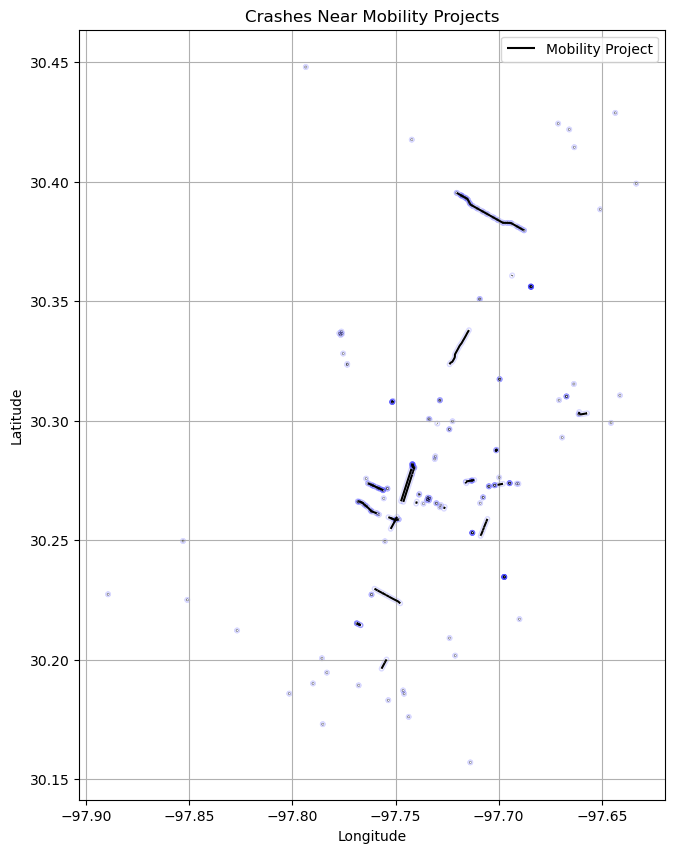

In [122]:
# Plot the mobility projects and crashes on a static map
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the buffered geometries (mobility projects)
buffered_moped_gdf.plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=1, alpha=0.15, label='Mobility Project Buffers')

# Plot the original line geometries (mobility projects)
gdf_moped.plot(ax=ax, color='black', label='Mobility Project')

# Plot the crash data points
# crashes_near_projects.plot(ax=ax, color='red', markersize=5, label='Crashes within Buffer')

# Enhance the plot with titles and legend
ax.set_title('Crashes Near Mobility Projects')
plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)

plt.show()

In [123]:
crashes_near_projects.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9137 entries, 124 to 398440
Data columns (total 21 columns):
 #   Column                                 Non-Null Count  Dtype              
---  ------                                 --------------  -----              
 0   id                                     9137 non-null   int64              
 1   crash_id                               9137 non-null   int64              
 2   crash_fatal_fl                         9137 non-null   object             
 3   crash_date                             9137 non-null   object             
 4   rpt_latitude                           902 non-null    float64            
 5   rpt_longitude                          902 non-null    float64            
 6   road_constr_zone_fl                    9137 non-null   object             
 7   latitude                               9137 non-null   float64            
 8   longitude                              9137 non-null   float64            
 9   tot_injry

In [ ]:
crashes_near_projects.sort_values('moped_project_id')

,id,crash_id,crash_fatal_fl,crash_date,rpt_latitude,rpt_longitude,road_constr_zone_fl,latitude,longitude,tot_injry_cnt,...,geometry_left,index_right,moped_project_id,project_id,project_component_id,geometry_right,line_geometry,substantial_completion_date_estimated,completion_date,completion_end_date
31548,8528,11566998,N,2010-08-13,NaN,NaN,N,30.266958,-97.734223,1.0,...,POINT (-97.73422 30.26696),4,1,12,181.0,MULTIPOINT (-97.73351 30.26751),"LINESTRING (621833.101 3349106.852, 621832.966...",2024-01-01T00:00:00-06:00,NaT,2022-12-30 06:00:00+00:00
221531,8548,15109570,N,2016-04-03,NaN,NaN,N,30.268397,-97.733639,0.0,...,POINT (-97.73364 30.26840),4,1,12,181.0,MULTIPOINT (-97.73351 30.26751),"LINESTRING (621833.101 3349106.852, 621832.966...",2024-01-01T00:00:00-06:00,NaT,2022-12-30 06:00:00+00:00
197824,8547,20228708,N,2024-06-08,NaN,NaN,N,30.266808,-97.734222,0.0,...,POINT (-97.73422 30.26681),4,1,12,181.0,MULTIPOINT (-97.73351 30.26751),"LINESTRING (621833.101 3349106.852, 621832.966...",2024-01-01T00:00:00-06:00,NaT,2022-12-30 06:00:00+00:00
173401,8546,14431886,N,2015-05-07,NaN,NaN,N,30.266924,-97.734179,0.0,...,POINT (-97.73418 30.26692),4,1,12,181.0,MULTIPOINT (-97.73351 30.26751),"LINESTRING (621833.101 3349106.852, 621832.966...",2024-01-01T00:00:00-06:00,NaT,2022-12-30 06:00:00+00:00
170416,8545,15017789,N,2016-04-03,NaN,NaN,N,30.268449,-97.733620,0.0,...,POINT (-97.73362 30.26845),4,1,12,181.0,MULTIPOINT (-97.73351 30.26751),"LINESTRING (621833.101 3349106.852, 621832.966...",2024-01-01T00:00:00-06:00,NaT,2022-12-30 06:00:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375211,9081,11546388,N,2010-07-19,NaN,NaN,N,30.273145,-97.761822,1.0,...,POINT (-97.76182 30.27314),12061,196,3492,12353.0,MULTIPOINT (-97.76084 30.27272),"LINESTRING (619197.160 3349655.737, 619197.025...",2024-01-01T00:00:00-06:00,NaT,2020-02-01 06:00:00+00:00
375561,9082,11672334,N,2010-10-01,NaN,NaN,N,30.273149,-97.761832,0.0,...,POINT (-97.76183 30.27315),12061,196,3492,12353.0,MULTIPOINT (-97.76084 30.27272),"LINESTRING (619197.160 3349655.737, 619197.025...",2024-01-01T00:00:00-06:00,NaT,2020-02-01 06:00:00+00:00
396943,9083,13094638,N,2013-01-14,NaN,NaN,N,30.273116,-97.761750,2.0,...,POINT (-97.76175 30.27312),12061,196,3492,12353.0,MULTIPOINT (-97.76084 30.27272),"LINESTRING (619197.160 3349655.737, 619197.025...",2024-01-01T00:00:00-06:00,NaT,2020-02-01 06:00:00+00:00
408749,9084,12662603,N,2012-04-13,NaN,NaN,N,30.273137,-97.761804,0.0,...,POINT (-97.76180 30.27314),12061,196,3492,12353.0,MULTIPOINT (-97.76084 30.27272),"LINESTRING (619197.160 3349655.737, 619197.025...",2024-01-01T00:00:00-06:00,NaT,2020-02-01 06:00:00+00:00


# Analysis

In [129]:
# Converting crash date to datetime format
crashes_near_projects['crash_date'] = pd.to_datetime(crashes_near_projects['crash_date']).dt.tz_localize('UTC', nonexistent='NaT', ambiguous='NaT')

In [130]:
crashes_near_projects.head()

,id,crash_id,crash_fatal_fl,crash_date,rpt_latitude,rpt_longitude,road_constr_zone_fl,latitude,longitude,tot_injry_cnt,...,geometry_left,index_right,moped_component_id,project_id,project_component_id,geometry_right,line_geometry,substantial_completion_date_estimated,completion_date,completion_end_date
124,1,11883667,N,2011-01-19 00:00:00+00:00,NaN,NaN,N,30.268945,-97.738652,0.0,...,POINT (-97.73865 30.26894),3016,39,3487,12312.0,"MULTILINESTRING ((-97.73860 30.26895, -97.7384...","MULTILINESTRING ((621334.736 3349261.391, 6213...",2024-01-01T00:00:00-06:00,NaT,2020-08-01 05:00:00+00:00
812,2,12148171,N,2011-06-17 00:00:00+00:00,NaN,NaN,N,30.268945,-97.738652,0.0,...,POINT (-97.73865 30.26894),3016,39,3487,12312.0,"MULTILINESTRING ((-97.73860 30.26895, -97.7384...","MULTILINESTRING ((621334.736 3349261.391, 6213...",2024-01-01T00:00:00-06:00,NaT,2020-08-01 05:00:00+00:00
34940,3,13828948,N,2014-05-04 00:00:00+00:00,NaN,NaN,N,30.268869,-97.738347,0.0,...,POINT (-97.73835 30.26887),3016,39,3487,12312.0,"MULTILINESTRING ((-97.73860 30.26895, -97.7384...","MULTILINESTRING ((621334.736 3349261.391, 6213...",2024-01-01T00:00:00-06:00,NaT,2020-08-01 05:00:00+00:00
58099,4,15857296,N,2017-07-10 00:00:00+00:00,NaN,NaN,N,30.268945,-97.738652,1.0,...,POINT (-97.73865 30.26894),3016,39,3487,12312.0,"MULTILINESTRING ((-97.73860 30.26895, -97.7384...","MULTILINESTRING ((621334.736 3349261.391, 6213...",2024-01-01T00:00:00-06:00,NaT,2020-08-01 05:00:00+00:00
62361,5,15618026,N,2017-02-28 00:00:00+00:00,NaN,NaN,N,30.268945,-97.738652,1.0,...,POINT (-97.73865 30.26894),3016,39,3487,12312.0,"MULTILINESTRING ((-97.73860 30.26895, -97.7384...","MULTILINESTRING ((621334.736 3349261.391, 6213...",2024-01-01T00:00:00-06:00,NaT,2020-08-01 05:00:00+00:00


In [131]:
# Creating indicator variables for crash occuring pre and post completion of mobility project
crashes_near_projects['before_construction'] = crashes_near_projects['crash_date'] < crashes_near_projects['completion_end_date']
crashes_near_projects['after_construction'] = crashes_near_projects['crash_date'] > crashes_near_projects['completion_end_date']

In [132]:
crashes_near_projects.head()

,id,crash_id,crash_fatal_fl,crash_date,rpt_latitude,rpt_longitude,road_constr_zone_fl,latitude,longitude,tot_injry_cnt,...,moped_component_id,project_id,project_component_id,geometry_right,line_geometry,substantial_completion_date_estimated,completion_date,completion_end_date,before_construction,after_construction
124,1,11883667,N,2011-01-19 00:00:00+00:00,NaN,NaN,N,30.268945,-97.738652,0.0,...,39,3487,12312.0,"MULTILINESTRING ((-97.73860 30.26895, -97.7384...","MULTILINESTRING ((621334.736 3349261.391, 6213...",2024-01-01T00:00:00-06:00,NaT,2020-08-01 05:00:00+00:00,True,False
812,2,12148171,N,2011-06-17 00:00:00+00:00,NaN,NaN,N,30.268945,-97.738652,0.0,...,39,3487,12312.0,"MULTILINESTRING ((-97.73860 30.26895, -97.7384...","MULTILINESTRING ((621334.736 3349261.391, 6213...",2024-01-01T00:00:00-06:00,NaT,2020-08-01 05:00:00+00:00,True,False
34940,3,13828948,N,2014-05-04 00:00:00+00:00,NaN,NaN,N,30.268869,-97.738347,0.0,...,39,3487,12312.0,"MULTILINESTRING ((-97.73860 30.26895, -97.7384...","MULTILINESTRING ((621334.736 3349261.391, 6213...",2024-01-01T00:00:00-06:00,NaT,2020-08-01 05:00:00+00:00,True,False
58099,4,15857296,N,2017-07-10 00:00:00+00:00,NaN,NaN,N,30.268945,-97.738652,1.0,...,39,3487,12312.0,"MULTILINESTRING ((-97.73860 30.26895, -97.7384...","MULTILINESTRING ((621334.736 3349261.391, 6213...",2024-01-01T00:00:00-06:00,NaT,2020-08-01 05:00:00+00:00,True,False
62361,5,15618026,N,2017-02-28 00:00:00+00:00,NaN,NaN,N,30.268945,-97.738652,1.0,...,39,3487,12312.0,"MULTILINESTRING ((-97.73860 30.26895, -97.7384...","MULTILINESTRING ((621334.736 3349261.391, 6213...",2024-01-01T00:00:00-06:00,NaT,2020-08-01 05:00:00+00:00,True,False


In [133]:
# Group by 'moped_component_id' and calculate the number of unique crashes before and after completion
before_group = crashes_near_projects[crashes_near_projects['before_construction']].groupby('moped_component_id')['crash_id'].nunique()
after_group = crashes_near_projects[crashes_near_projects['after_construction']].groupby('moped_component_id')['crash_id'].nunique()

# Combine results into a DataFrame for clarity
results = pd.DataFrame({
    'before_construction': before_group,
    'after_construction': after_group
}).fillna(0)  # Replace NaNs with 0 for components without crashes

print(results)

                    before_construction  after_construction
moped_component_id                                         
1                                  48.0                 3.0
4                                  38.0                 7.0
6                                   1.0                 0.0
7                                   3.0                 1.0
8                                   1.0                 0.0
...                                 ...                 ...
192                                 2.0                 1.0
193                                 2.0                 0.0
194                                 2.0                 1.0
195                                 3.0                 0.0
196                                 5.0                 1.0

[161 rows x 2 columns]


In [134]:
results.to_csv('crash_counts.csv', index=True)